In [1]:
#Importing the important libraries and dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#load and dump
import pickle
# ### Importing the Dataset
data = pd.read_csv("spam.csv",encoding='latin1')
data.sample(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3614,ham,I enjoy watching and playing football and bask...,NaN,NaN,NaN
2263,spam,Not heard from U4 a while. Call 4 rude chat pr...,NaN,NaN,NaN
1645,ham,I.ll post her out l8r. In class,NaN,NaN,NaN
4270,spam,Natalja (25/F) is inviting you to be her frien...,NaN,NaN,NaN
978,ham,Hey you can pay. With salary de. Only &lt;#&g...,NaN,NaN,NaN


In [2]:
#Initial Exploration And Data Cleaning
data.shape
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)
data
data.isnull().sum()
data.duplicated().sum()
data = data.drop_duplicates(keep='first')
data.shape
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


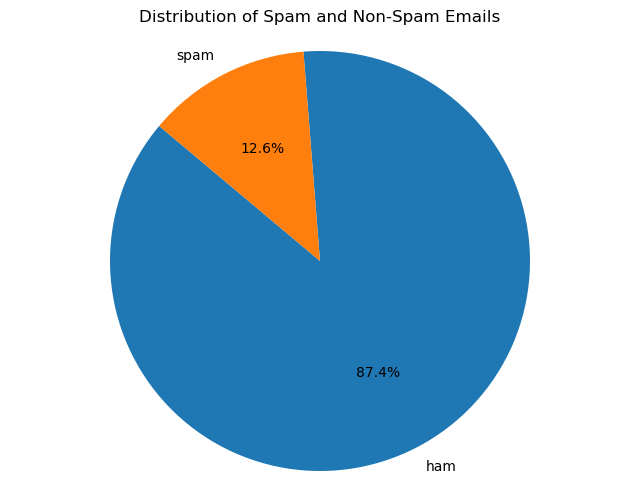

In [3]:
#Exploratory Data Analysis (EDA)
data['result'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal') 
plt.show()

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


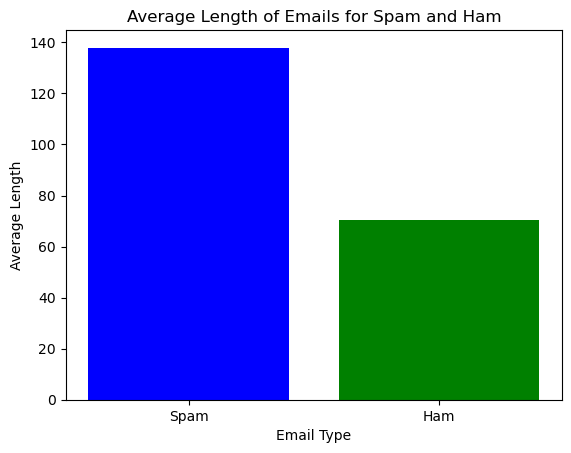

In [4]:
# Average Length of Emails for Spam and Ham
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Average Words of Spam Emails: 27.6676875957121
Average Words of Ham Emails: 17.12378210806023


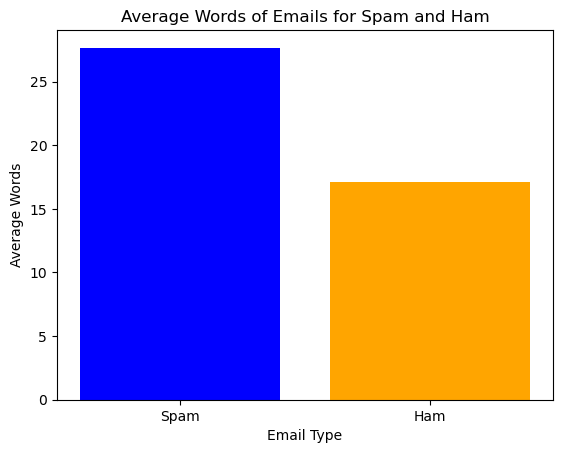

In [5]:
#Average Word of Emails for Spam and Ham
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

Average Sentence of Spam Emails: 2.970903522205207
Average Sentence of Ham Emails: 1.8201948627103632


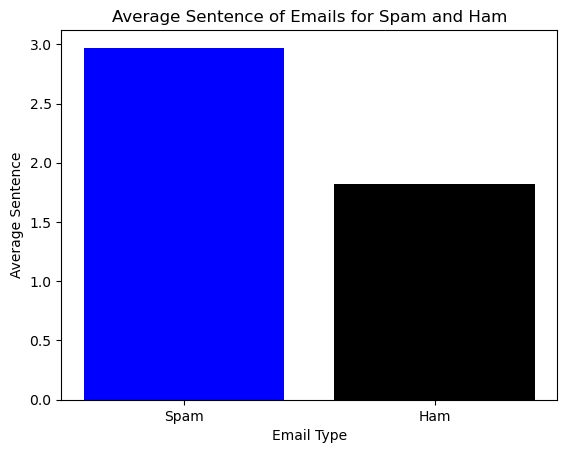

In [6]:
#Average Sentence of Emails for Spam and Ham
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

Correlation coefficient between email length and spam classification: 0.38471706671430766


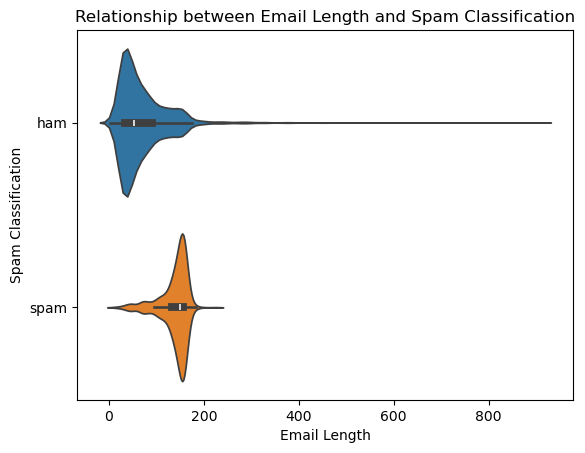

In [7]:
#Relationship between Length and Spam
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)


sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


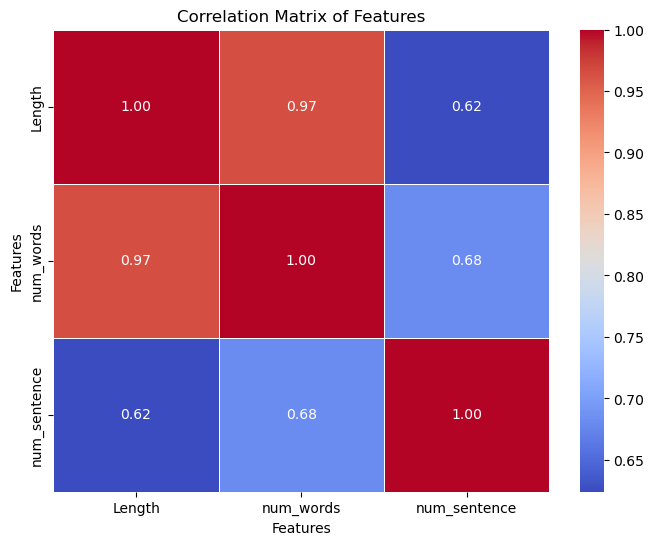

In [8]:
#Relationship between Features
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are ",correlation_matrix )
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [9]:
#Data Preprocessing
data['transform_text'] = data['emails'].str.lower()
# Tokenization
data['transform_text'] = data['transform_text'].apply(word_tokenize)

# Removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# Removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display the preprocessed data
print(data[['emails', 'transform_text']].head())

                                              emails  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though  


Top 10 Most Common Words in Spam Emails:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


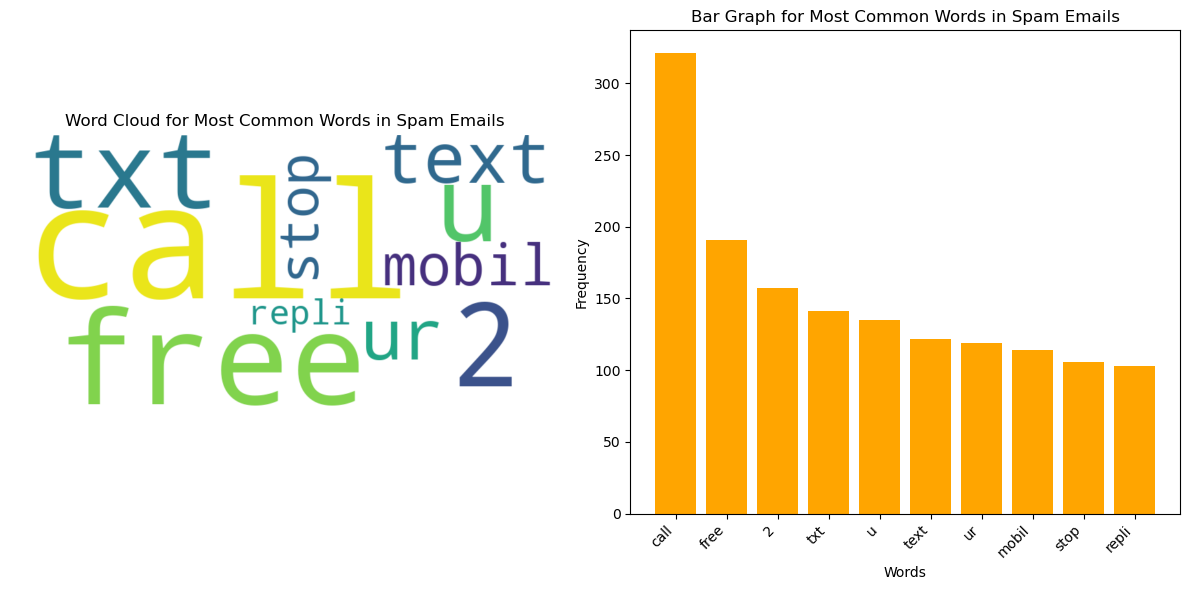

In [10]:
#Most Common Words in Spam Emails
spam_emails = data[data['result'] == 'spam']['transform_text']
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()
# Count occurrences of each word
word_counts = Counter(spam_words)
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top 10 Most Common Words in ham Emails:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


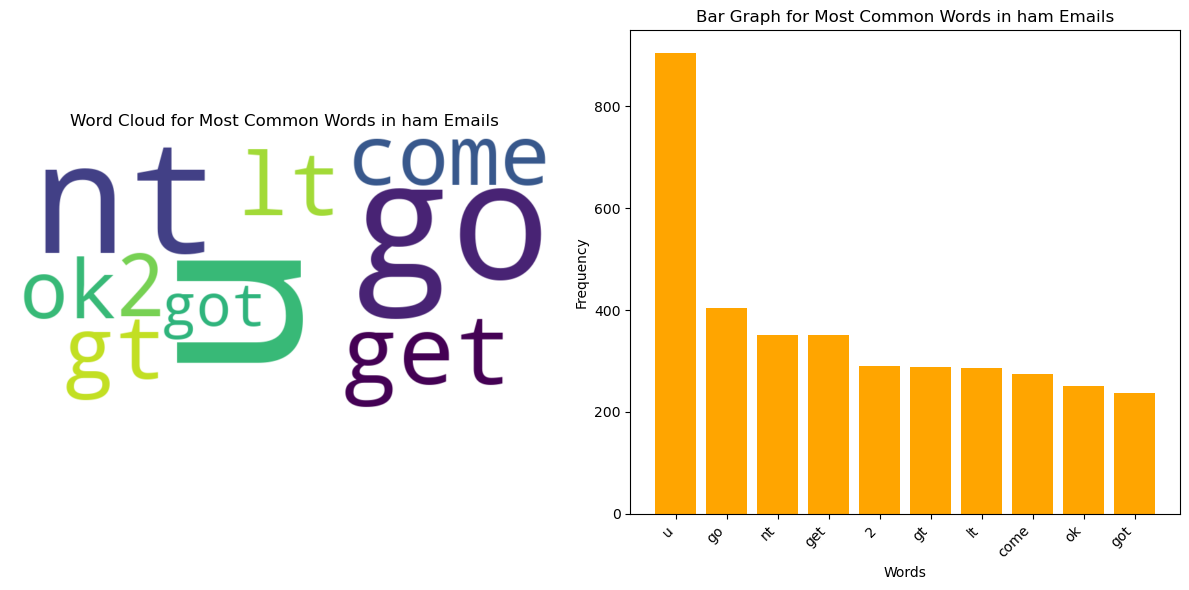

In [11]:
#Most Common Words in Ham Emails
ham_emails = data[data['result'] == 'ham']['transform_text']
# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()
# Count occurrences of each word
word_counts = Counter(ham_words)
# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
#Preparing Data for Machine Learning: Label Encoding and Vectorization
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])
data.sample(2)

#data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['emails']).toarray()
y = data['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#Model Building

In [14]:
#Model 1- SVC
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.99
confusion Matrix : [[889   0]
 [ 14 131]]
Precision Score:  1.0


In [15]:
#Model 2- Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.98
confusion Matrix : [[888   1]
 [ 19 126]]
Precision Score:  0.9921259842519685


In [16]:
#Model 3- Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.98
confusion Matrix : [[889   0]
 [ 24 121]]
Precision Score:  1.0


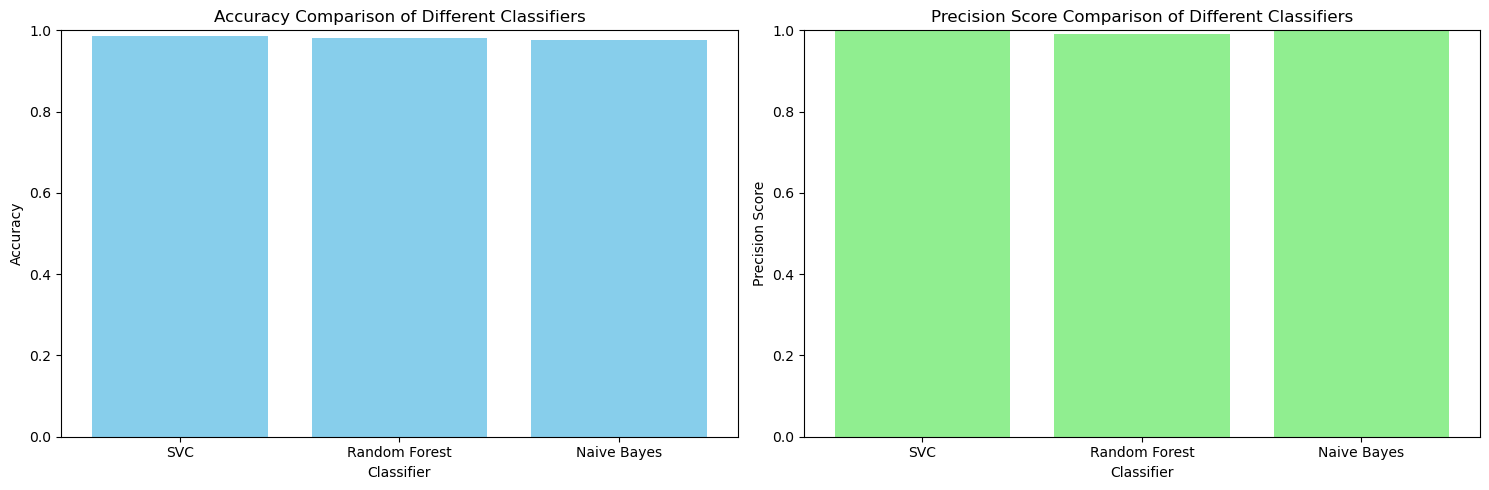

In [17]:
#Choosing the Best Classifier for Email Spam Detection
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [18]:
#Model Prediction
#Predict with new data
new_emails = [
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = svc_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as spam.
'Hey, how's it going?' is predicted as ham.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


## User Input Data Prediction
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])
    
    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()
    
    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)
    
    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

In [19]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])
    
    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()
    
    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)
    
    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

Enter the email text:  Subject: Congratulations! You've Won a Prize!  Hi there,  Congratulations! You've been selected as the lucky winner of our grand prize. To claim your reward, simply click on the link below and follow the instructions. Don't miss out on this amazing opportunity!  [Claim Your Prize Now]


The email is predicted as spam.


In [21]:
# Save your trained artifacts
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
